# Task 4: Decomposition

A common challenge in the design and implementation of quantum circuits is that they become too extensive and complex due to the large number of qubits required.

The number of quantum operations and the interdependence between qubits can further complicate the problem, making some traditional optimization methods ineffective or insufficient for reducing the complexity. Additionally, as the number of qubits increases, the fidelity of the circuit may be affected, which implies a greater need for advanced techniques to maintain the precision of operations.

On the other hand, some quantum computing frameworks offer predefined optimization methods that may seem like a convenient option. However, they are not always the best alternative if one has a deep understanding of the quantum hardware structure. Customizing the circuits by taking advantage of the specific features of the quantum device in use can result in a more efficient design, better adapted to the physical limitations of the system. Therefore, having a solid understanding of the hardware can make the difference between a generic quantum circuit and one that is highly optimized for performance.

## Challenge

Consider the following code as input:

```python
import numpy as np

size = 5
state_values = [22, 17, 27, 12]

state_vector = [0]*2**size

for s in state_values:
    print(np.binary_repr(s, size))
    state_vector[s] = 0.5

np.asarray(state_vector)


Find a quantum circuit that represents the state vector with a depth less than 50, using the basis_gates=[x,h,rz,cx] and the following architecture

<img src="layout.png" alt="drawing" width="400"/>

In [28]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap
from qiskit.visualization import plot_coupling_map, state_visualization, plot_histogram
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator

import matplotlib.pyplot as plt
from IPython.display import Latex, display

import time
from qiskit.quantum_info import state_fidelity

In [7]:
size = 5
state_values = [22, 17, 27, 12]
state_vector = [0] * 2**size
for s in state_values:
    state_vector[s] = 0.5

state_to_latex = state_visualization._state_to_latex_ket(state_vector, max_size = 128)
display(Latex("$$" + state_to_latex + "$$"))

<IPython.core.display.Latex object>

In [11]:
# Define the coupling map based on the provided connectivity
coupling_map_list = [(0, 4), (1, 4), (2, 4), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (0, 1), (1, 0), (2, 3), (3, 2)]
coupling_map = CouplingMap(coupling_map_list)

basis_gates = ['x', 'h', 'rz', 'cx']
simulator = AerSimulator(coupling_map=coupling_map)

# plot_coupling_map(
#     simulator.coupling_map.size(),
#     qubit_coordinates=None,
#     coupling_map=simulator.coupling_map.get_edges()
# )

In [12]:
# Define the number of qubits
num_qubits = 5
qc = QuantumCircuit(num_qubits)

# Create superposition on the first 2 qubits (qubits 0, 1)
qc.h([0, 1])

# Use controlled operations to create the desired states
# State |01100⟩
qc.x(0)
qc.x(1) 
qc.ccx(0, 1, 2) 
qc.ccx(0, 1, 3)   
qc.x(0) 
qc.x(1)

# State |10001⟩
qc.x(1)
qc.ccx(0, 1, 4)
qc.x(1)

# State |10110⟩
qc.x(0)
qc.ccx(0, 1, 2)
qc.ccx(0, 1, 4)
qc.x(0)

# State |11011⟩
qc.ccx(0, 1, 3)
qc.ccx(0, 1, 4)
qc.measure_all()

Counts: {'01100': 2467, '11011': 2477, '10001': 2482, '10110': 2574}
Circuit depth: 137


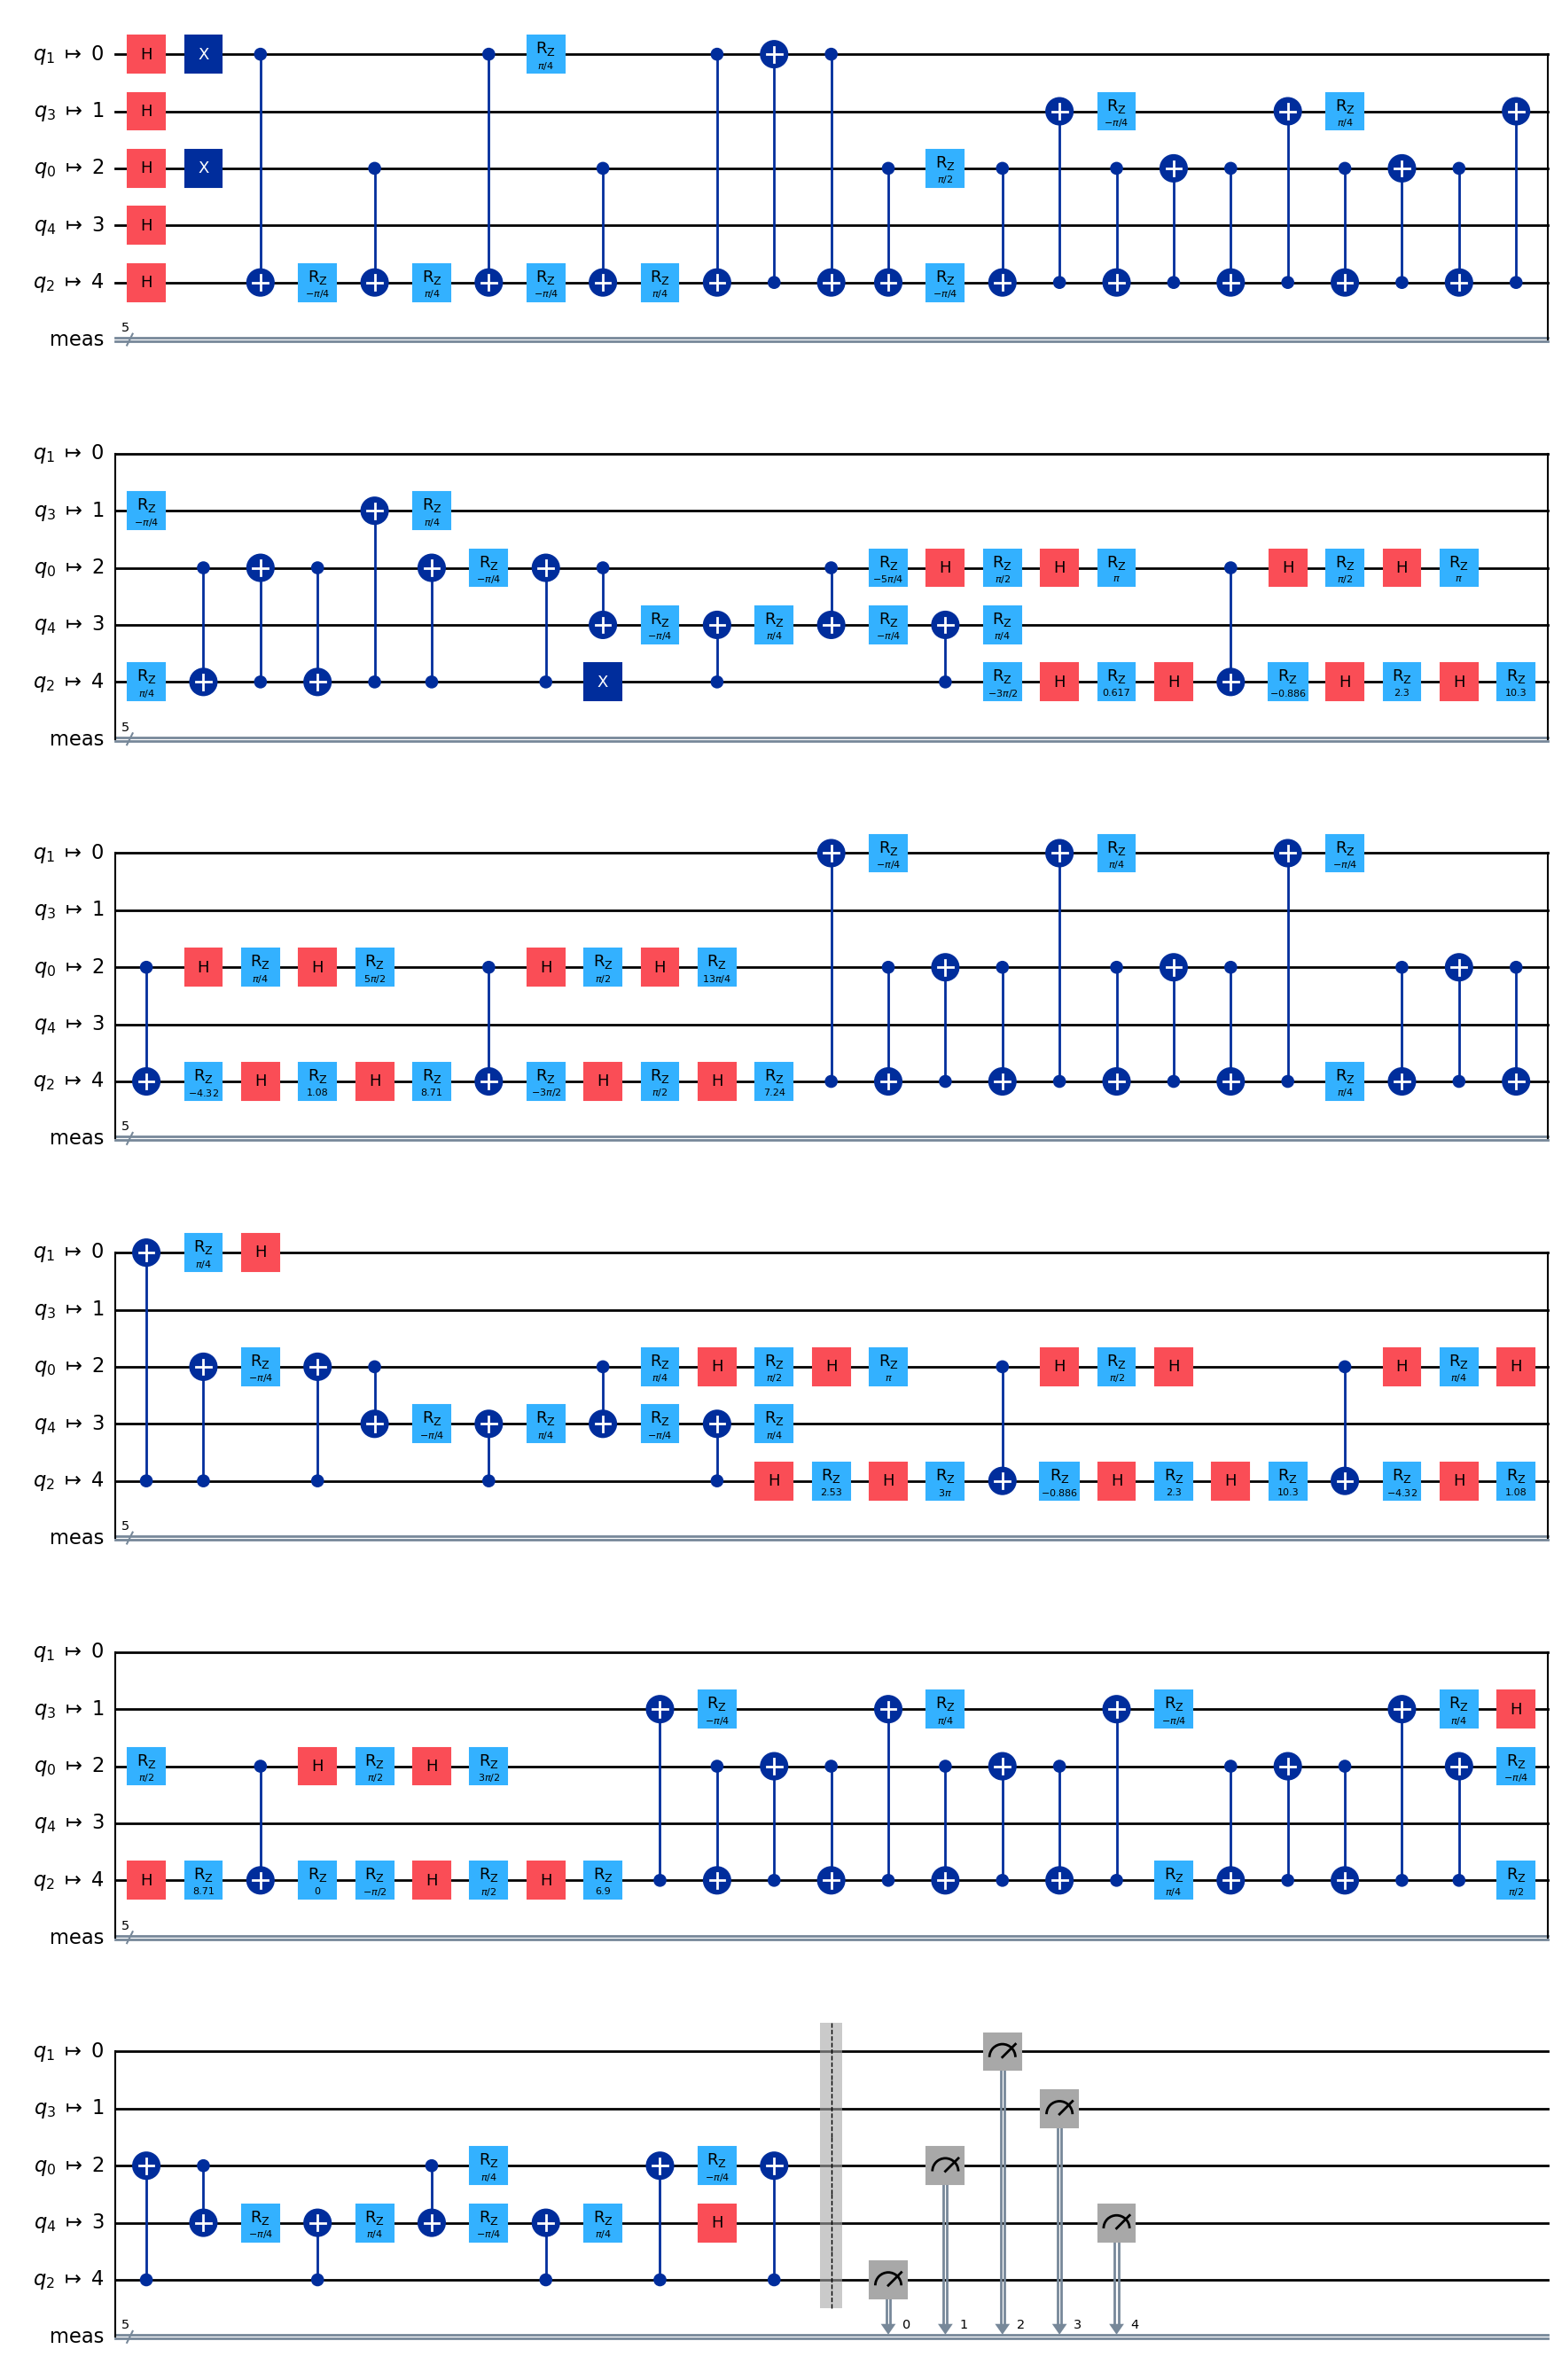

In [17]:
transpiled_qc = transpile(
    qc,
    backend=simulator,
    basis_gates=basis_gates,
    optimization_level=2
)

# Simulate the circuit
result = simulator.run(transpiled_qc, shots=10000).result()
counts = result.get_counts()

# Display the counts and circuit depth
print("Counts:", counts)
print("Circuit depth:", transpiled_qc.depth())

# Draw the transpiled circuit for visual verification
transpiled_qc.draw('mpl', filename='plots/original_circuit.png')


In [32]:
def state_to_counts(state_vector):
    counts = {}
    num_qubits = int(np.log2(len(state_vector)))
    for idx, amplitude in enumerate(state_vector):
        # Calculate the probability of each state
        probability = np.abs(amplitude)**2

        if probability > 0:
            # Convert the index to its binary form with leading zeros
            binary_state = format(idx, f'0{num_qubits}b')
            counts[binary_state] = probability

    return counts

def counts_to_state(counts):
  total_counts = sum(counts.values())
  probabilities = {key: value / total_counts for key, value in counts.items()}

  # Construct a state vector from the probabilities
  # Create an empty state vector with the required number of qubits (log2 of number of states)
  num_qubits = len(next(iter(counts)))  # Calculate number of qubits from key length
  state_vector = np.zeros(2**num_qubits, dtype=complex)

  # Fill the state vector with the square root of the probabilities
  for state, prob in probabilities.items():
      index = int(state, 2)  # Convert the binary state to an integer index
      state_vector[index] = np.sqrt(prob)

  # Normalize the state vector to ensure it has unit length
  state_vector /= np.linalg.norm(state_vector)

  # Convert to a Qiskit Statevector object
  qiskit_state = Statevector(state_vector)
  return qiskit_state

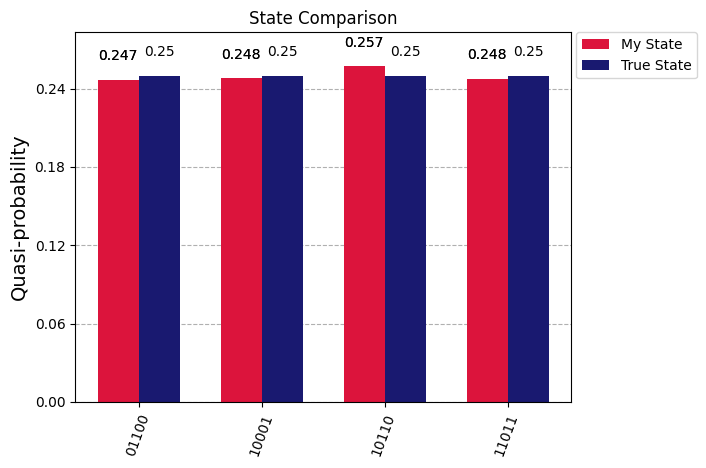

In [40]:
counts1 = counts
counts2 = state_to_counts(state_vector)

legend = ['My State', 'True State']

plot_histogram([counts1, counts2], legend=legend, color=['crimson','midnightblue'],
                title="State Comparison", filename='plots/state_comparison.png')
plot_histogram([counts1, counts2], legend=legend, color=['crimson','midnightblue'],
                title="State Comparison")

Quantum AutoEncoder

In [41]:
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA

In [42]:
def train_autoencoder(input_state, reps=5, maxiter=150, is_display=False):
    def ansatz(num_qubits):
        return RealAmplitudes(num_qubits, reps=reps)

    def autoencoder_circuit(input_state, display):
        num_qubits = int(np.log2(len(input_state)))
        circuit = QuantumCircuit(num_qubits)
        circuit.initialize(input_state, range(num_qubits))
        circuit.compose(ansatz(num_qubits), range(num_qubits), inplace=True)
        circuit.measure_all()
        # Display the circuit
        if is_display:
          display(circuit.draw('mpl', filename='plots/ae_circuit.png'))
        return circuit

    def cost_func(params, qnn):
        probabilities = qnn.forward([], params)
        return -probabilities[0, 0]

    ae_circuit = autoencoder_circuit(input_state, display)
    qnn = SamplerQNN(circuit=ae_circuit, weight_params=ae_circuit.parameters, output_shape=2)
    optimizer = COBYLA(maxiter=maxiter)
    initial_point = np.random.random(ae_circuit.num_parameters)
    result = optimizer.minimize(lambda p: cost_func(p, qnn), initial_point)
    return result.x

def get_autoencoder(params, input_state, reps=5):
  def ansatz(num_qubits):
      return RealAmplitudes(num_qubits, reps=reps)
  num_qubits = int(np.log2(len(input_state)))
  qc = QuantumCircuit(num_qubits)
  qc.compose(ansatz(num_qubits).inverse(), inplace=True)
  qc.assign_parameters(params, inplace=True)
  qc.measure_all()
  return qc

def predict_autoencoder(params, input_state, simulator, basis_gates, coupling_map, reps=5):
    qc = get_autoencoder(params, input_state, reps=reps)
    transpiled_qc = transpile(
        qc,
        backend=simulator,
        basis_gates=basis_gates,
        coupling_map=coupling_map,
        optimization_level=2
    )
    result = simulator.run(transpiled_qc, shots=10000).result()
    counts = result.get_counts()
    state_vector = counts_to_state(counts)
    return state_vector


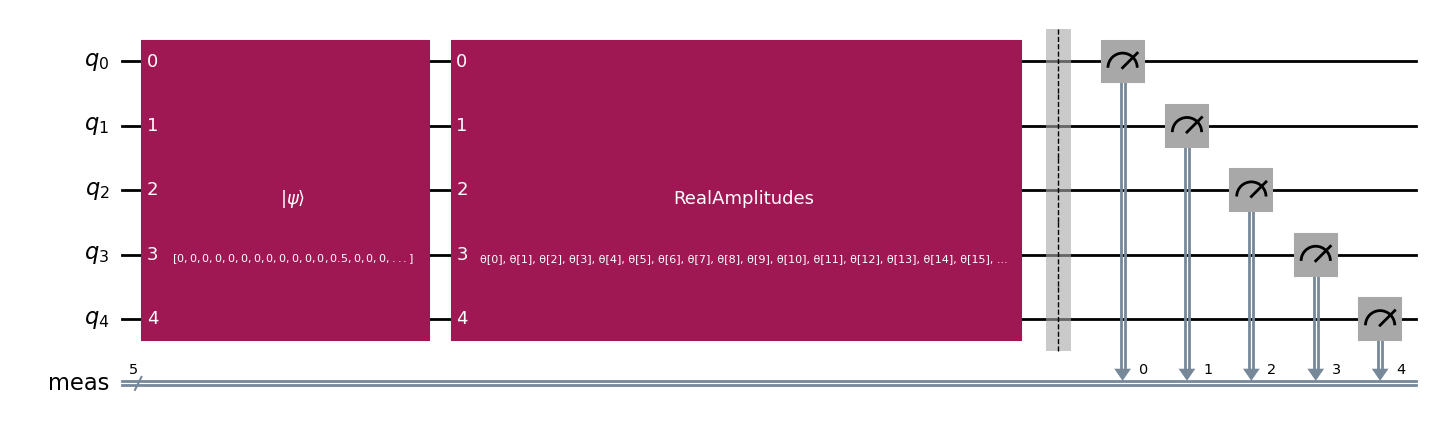

No interpret function given, output_shape will be automatically determined as 2^num_qubits.


Trained Parameters: [ 1.57034440e+00  1.81358790e+00  1.25245916e-02  2.90221488e-01
  7.85776208e-01  1.54302029e+00  2.93423256e+00  1.57111666e+00
  2.08787050e-01  7.73310519e-01  1.57456888e+00  1.57186640e+00
  1.47247276e+00 -1.12428931e-02 -3.51620051e-02 -2.28656921e-01
 -9.00313092e-03  1.09061757e-03 -8.79846105e-03 -1.77794678e-03
  2.24192270e-01 -1.57204580e+00 -1.46961198e-01 -1.46760746e-01
  1.56998023e+00  2.03469845e-01 -4.82314025e-02  8.06661197e-01
 -1.40546984e-01  7.89702805e-01]
Predicted State: Statevector([0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.49477268+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.50179677+0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.50109879+0.j, 0.

In [43]:
reps = 5
# Train the autoencoder
trained_params = train_autoencoder(input_state=state_vector, reps=reps, maxiter=2000, is_display=True)
print("Trained Parameters:", trained_params)

# Predict using the trained autoencoder
predicted_state = predict_autoencoder(trained_params, state_vector, simulator, basis_gates, coupling_map, reps=reps)
print("Predicted State:", predicted_state)

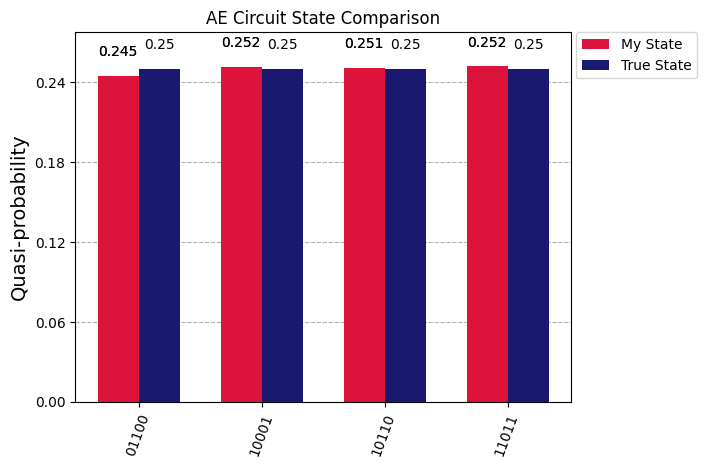

In [44]:
counts1 = state_to_counts(predicted_state)
counts2 = state_to_counts(state_vector)

legend = ['My State', 'True State']

plot_histogram([counts1, counts2], legend=legend, color=['crimson','midnightblue'],
                title="AE Circuit State Comparison", filename='plots/ae_state_comparison.png')
plot_histogram([counts1, counts2], legend=legend, color=['crimson','midnightblue'],
                title="AE Circuit State Comparison")

In [48]:
reps_values = range(1, 11)
maxiter = 2000

depths = []
fidelities = []
times = []
circuits = []
for reps in reps_values:
    print(f"\nProcessing reps = {reps}")
    # Train the autoencoder
    trained_params = train_autoencoder(input_state=state_vector, reps=reps, maxiter=maxiter, is_display=False)
    # Predict using the trained autoencoder
    qc_pred = get_autoencoder(trained_params, state_vector, reps=reps)
    # Transpile the circuit
    transpiled_qc_pred = transpile(
        qc_pred,
        backend=simulator,
        basis_gates=basis_gates,
        coupling_map=coupling_map,
        optimization_level=3,
        seed_transpiler=99
    )

    modified_qc = transpiled_qc_pred.copy()

    # List to store indices of instructions to delete
    indices_to_delete = []
    for index, instruction in enumerate(modified_qc.data):
        if len(instruction.operation.params) == 1:
            # Get the parameter value
            param_value = float(instruction.operation.params[0])
            if abs(param_value) < 4e-2:
                indices_to_delete.append(index)

    # Delete instructions in reverse order to avoid index shifting
    for index in reversed(indices_to_delete):
        del modified_qc.data[index]

    # Re-transpile the modified circuit
    optimization_levels = [0, 1, 3, 2]
    for level in optimization_levels:
        modified_qc = transpile(
            modified_qc,
            backend=simulator,
            basis_gates=basis_gates,
            coupling_map=coupling_map,
            optimization_level=level,
            seed_transpiler=99
        )
    circuits.append(modified_qc)
    depth = modified_qc.depth()
    depths.append(depth)
    # Simulate the circuit to get counts
    st = time.time()
    result_pred = simulator.run(modified_qc, shots=8192).result()
    ed = time.time()
    times.append(ed-st)
    if result_pred.success:
        pred_counts = result_pred.get_counts()

        # Compute the fidelity with the original state
        fidelity = state_fidelity(state_vector, counts_to_state(pred_counts))
        fidelities.append(fidelity)
        print(f"Reps: {reps}, Fidelity: {fidelity:.5f}, Depth: {depth}")
    else:
        print(f"Simulation failed at reps = {reps}")
        fidelities.append(0)
        depths.append(0)


No interpret function given, output_shape will be automatically determined as 2^num_qubits.



Processing reps = 1


No interpret function given, output_shape will be automatically determined as 2^num_qubits.


Reps: 1, Fidelity: 0.49998, Depth: 24

Processing reps = 2


No interpret function given, output_shape will be automatically determined as 2^num_qubits.


Reps: 2, Fidelity: 0.72641, Depth: 30

Processing reps = 3


No interpret function given, output_shape will be automatically determined as 2^num_qubits.


Reps: 3, Fidelity: 0.84959, Depth: 33

Processing reps = 4


No interpret function given, output_shape will be automatically determined as 2^num_qubits.


Reps: 4, Fidelity: 0.99991, Depth: 39

Processing reps = 5


No interpret function given, output_shape will be automatically determined as 2^num_qubits.


Reps: 5, Fidelity: 0.99960, Depth: 50

Processing reps = 6


No interpret function given, output_shape will be automatically determined as 2^num_qubits.


Reps: 6, Fidelity: 0.99839, Depth: 54

Processing reps = 7


No interpret function given, output_shape will be automatically determined as 2^num_qubits.


Reps: 7, Fidelity: 0.99955, Depth: 61

Processing reps = 8


No interpret function given, output_shape will be automatically determined as 2^num_qubits.


Reps: 8, Fidelity: 0.99993, Depth: 72

Processing reps = 9


No interpret function given, output_shape will be automatically determined as 2^num_qubits.


Reps: 9, Fidelity: 0.99997, Depth: 79

Processing reps = 10
Reps: 10, Fidelity: 0.99982, Depth: 85


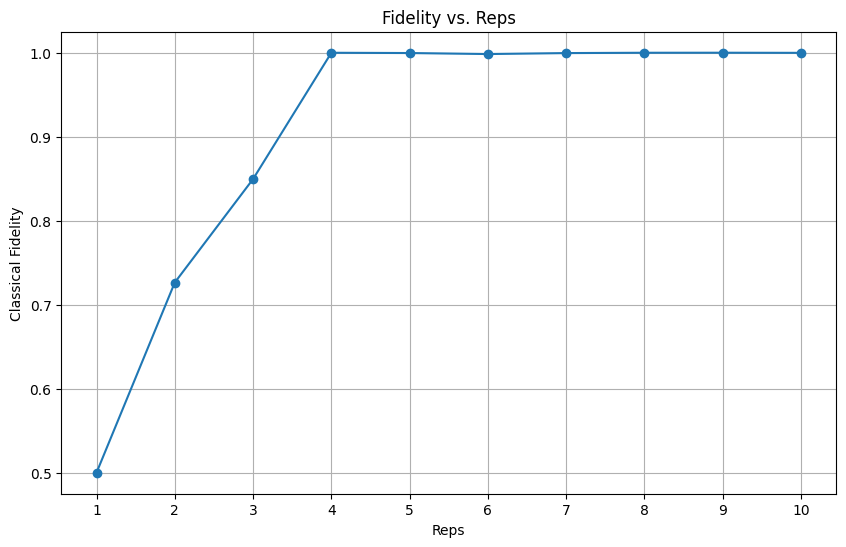

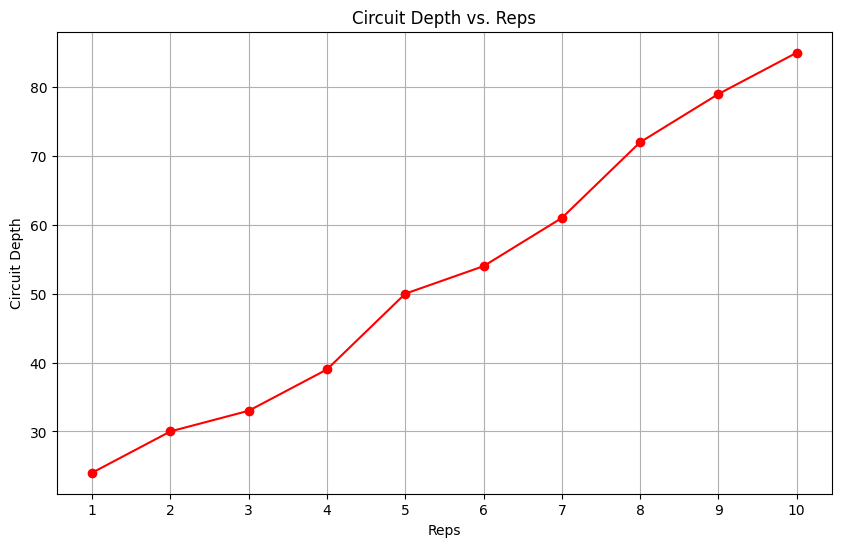

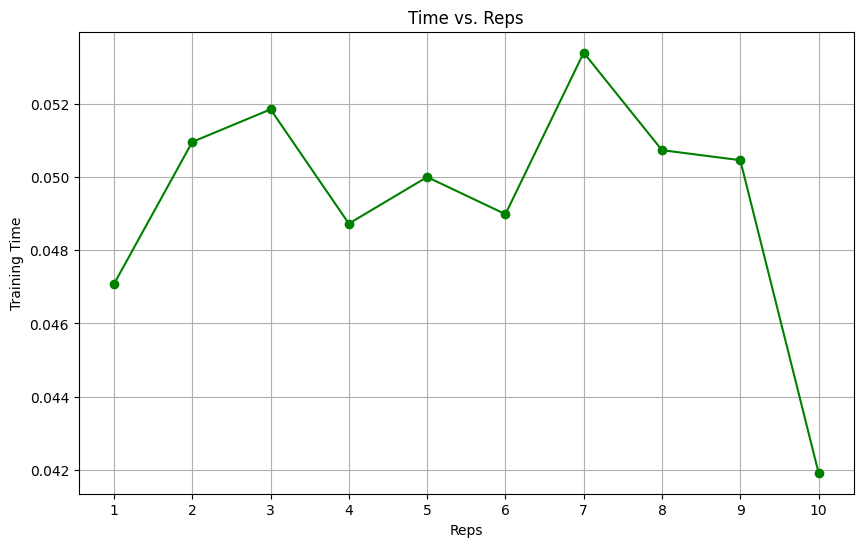

In [52]:
# Plot the fidelity vs. reps
plt.figure(figsize=(10, 6))
plt.plot(reps_values, fidelities, marker='o')
plt.title('Fidelity vs. Reps')
plt.xlabel('Reps')
plt.ylabel('Classical Fidelity')
plt.xticks(reps_values)
plt.grid(True)
plt.savefig('plots/fidelity_reps.png')
plt.show()

# Plot the depth vs. reps
plt.figure(figsize=(10, 6))
plt.plot(reps_values, depths, marker='o', color='red')
plt.title('Circuit Depth vs. Reps')
plt.xlabel('Reps')
plt.ylabel('Circuit Depth')
plt.xticks(reps_values)
plt.grid(True)
plt.savefig('plots/depth_reps.png')
plt.show()

# Plot the time vs. reps
plt.figure(figsize=(10, 6))
plt.plot(reps_values, times, marker='o', color='green')
plt.title('Time vs. Reps')
plt.xlabel('Reps')
plt.ylabel('Training Time')
plt.xticks(reps_values)
plt.grid(True)
plt.savefig('plots/time_reps.png')
plt.show()

Depth:  39


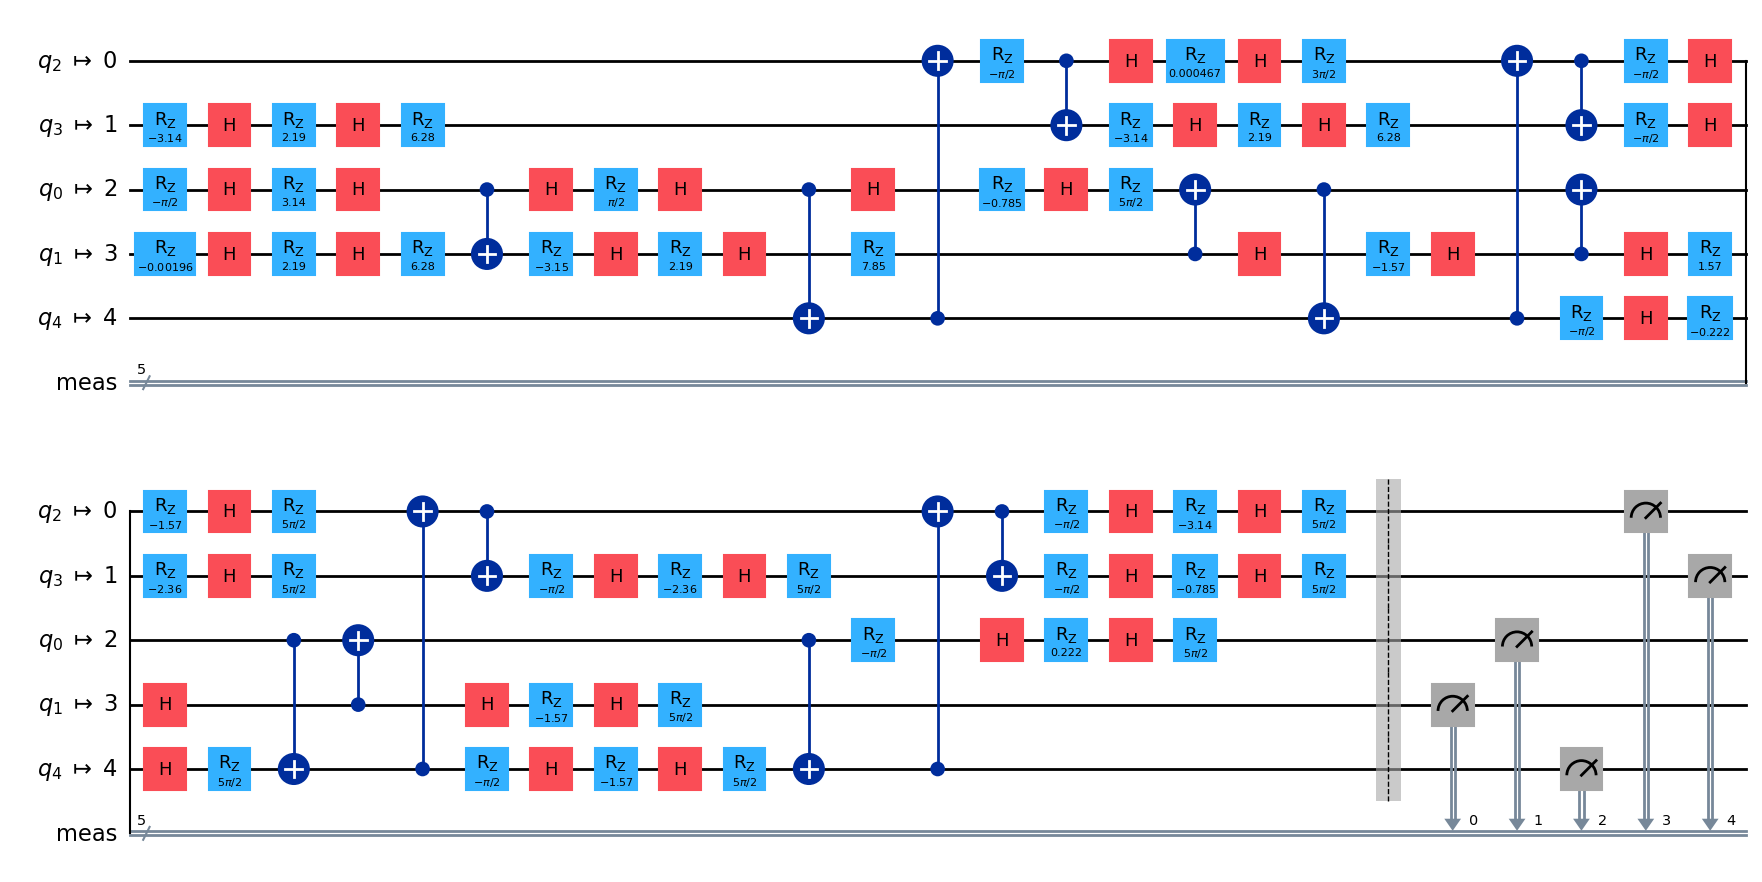

In [59]:
print("Depth: ", circuits[3].depth())
from qiskit import qpy
fi_3 = str(round(fidelities[3], 4)) # .replace('.', '-')
with open(f'depth_{circuits[3].depth()}_fidelity_{fi_3}_circuit.qpy', 'wb') as file:
    qpy.dump(circuits[3], file)

circuits[3].draw('mpl', filename=f'plots/depth_{circuits[3].depth()}_fidelity_{fi_3}_circuit.png')

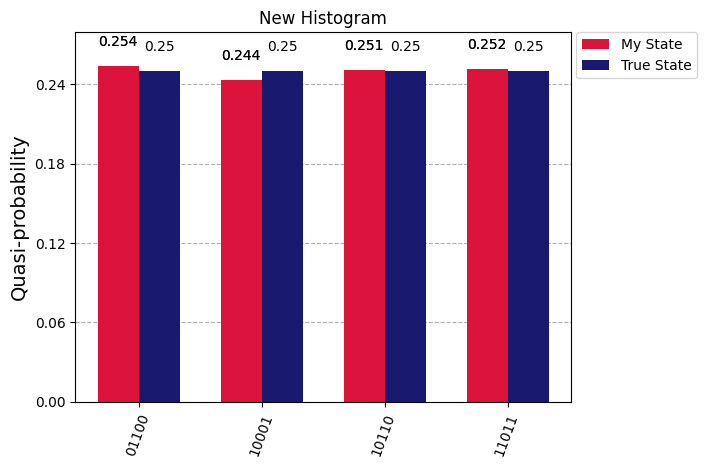

In [58]:
result = simulator.run(circuits[3], shots=10000).result()
counts = result.get_counts()
counts2 = state_to_counts(state_vector)

legend = ['My State', 'True State']

plot_histogram([counts, counts2], legend=legend, color=['crimson','midnightblue'],
                title="New Histogram")